I want to talk about using [kernal density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) to produce smoothed histograms.
I'm not a statician, I do machine learning -- _it's like statistics, but without the rigor_ --
and we are going to hand wave a lot of rigor.
Infact the phrase smooth histogram is probably annoying someone already.
<-- more -->

In [2]:
using Plots
using NamedColors
using Colors

In [3]:
data = convert.(HSV,collect(values(ALL_COLORS)))

In [36]:
hues = [datum.h/360 for datum in data if datum.h!=0]
sats = [datum.s for datum in data];


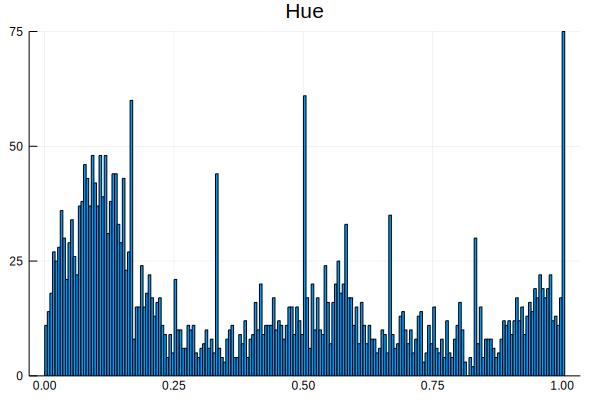

In [38]:
histogram(hues, nbins=256, title="Hue", legend=false)

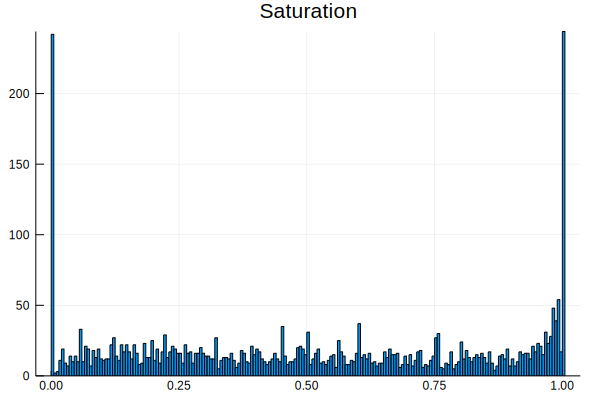

In [25]:
histogram(sats, nbins=256, title="Saturation", legend=false)

In [60]:
using KernelDensity


## Defining some smoothers
We are going to define some KDE based smoothed histograms.
We are going to define 4 functions.

 - `do_not_smooth` which just returns basically histogram.
 - `kde_smooth` which uses the kde normally,
 - `truncated_kde_smooth` which truncates the distribution at 0 and 1, (suitable for Value, and Saturation)
 - `wraparound_kde_smooth` which causes the distribution to wrap around at 0 and 1 (suitable for Hue)


### Do Not Smooth
This is basically a histogram.
We're abusing the internal `KernelDensity.tabulate` method for this.
It is slightly smarter than a simple method of binning,
as each datum contributes probability mass to 2 adjacent bins,
proportal to how close it is to the center of each.

In [179]:
function do_not_smooth(data, npoints)
    midpoints = KernelDensity.kde_range((0,1), npoints)
    dist = KernelDensity.tabulate(data, midpoints)
    dist.density./=sum(dist.density)
    dist.density, dist.x
end

do_not_smooth (generic function with 1 method)

In [177]:
function truncated_kde_smooth(data, npoints, kde_fun = kde_lscv)
    fake_boundry = (-0.5, 1.5)
    fake_npoints = 2npoints

    dist = kde_fun(data, npoints=fake_npoints, boundary=fake_boundry)
    density = dist.density
    density./=sum(density)
    inside = density[npoints÷2+1: end - npoints÷2]
    @assert length(inside)==npoints
    lower = @view density[1:npoints÷2]
    upper = @view density[end-npoints÷2+1:end]
    @assert length(lower)==npoints÷2
    @assert length(upper)==npoints÷2
    excess_mass = sum(lower) + sum(upper)
    @assert 0<=excess_mass<=0.5 
    inside./= 1-excess_mass
    @assert sum(inside)≈ 1
    inside, dist.x[npoints÷2+1: end - npoints÷2]
end

truncated_kde_smooth (generic function with 2 methods)

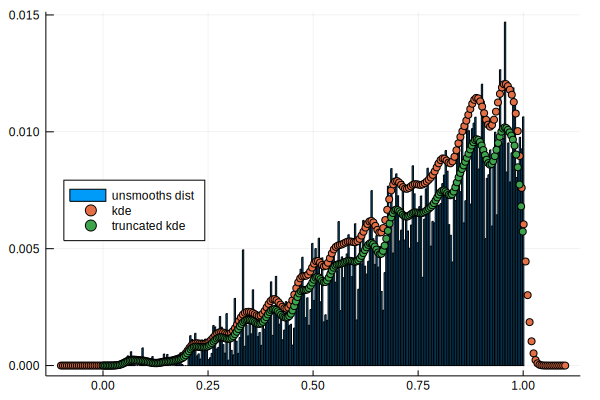

In [194]:
sat = cldata.train.colors[1:end÷900,2];
#histogram(sat, nbins=256; label="hist", norm=true, legend=:left)
ndist = do_not_smooth(sat, 256)
bar(ndist[2], ndist[1]; label="unsmooths dist", legend=:left)

dist = kde_lscv(sat, npoints=256, boundary=(-0.1,1.1))
scatter!(dist.x, dist.density./sum(dist.density) ; label="kde")
tdist = truncated_kde_smooth(sat, 256)
scatter!(tdist[2], tdist[1]; label="truncated kde")



In [136]:
function wraparound_kde_smooth(data, npoints)
    # Because of the periodic nature of FFT used to implement kde
    # It is actually wrap around by default
    # If you specify tight boundries
    boundry = (0, 1)
    dist = kde_lscv(data, npoints=npoints, boundary=boundry)
    dist.density./=sum(dist.density)
    
    dist.density, dist.x
end

wraparound_kde_smooth (generic function with 1 method)

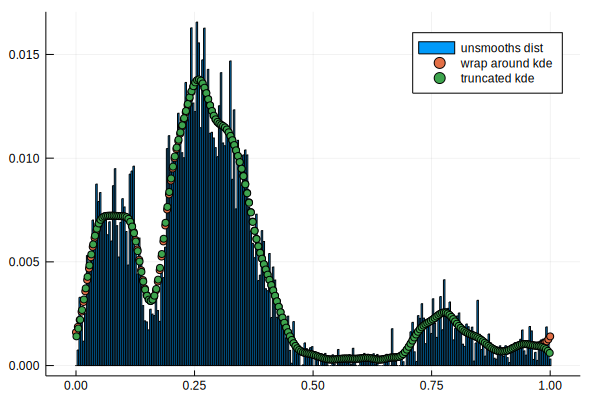

In [197]:
hue = cldata.train.colors[1:end÷900,1];
ndist = do_not_smooth(hue, 256)
bar(ndist[2], ndist[1]; label="unsmooths dist")
wdist = wraparound_kde_smooth(hue, 256)
scatter!(wdist[2], wdist[1]; label="wrap around kde")
tdist = truncated_kde_smooth(hue, 256)
scatter!(tdist[2], tdist[1]; label="truncated kde")


do_not_smooth (generic function with 1 method)

In [147]:
methods(KernelDensity.tabulate)

# 4 methods for generic function "tabulate":
tabulate(data::AbstractArray{T,1} where T<:Real, midpoints::Range) in KernelDensity at /home/wheel/oxinabox/.julia/v0.6/KernelDensity/src/univariate.jl:85
tabulate(data::AbstractArray{T,1} where T<:Real, midpoints::Range, weights::Union{AbstractArray{T,1} where T<:Real, KernelDensity.UniformWeights}) in KernelDensity at /home/wheel/oxinabox/.julia/v0.6/KernelDensity/src/univariate.jl:85
tabulate(data::Tuple{AbstractArray{T,1} where T<:Real,AbstractArray{T,1} where T<:Real}, midpoints::Tuple{Range,Range}) in KernelDensity at /home/wheel/oxinabox/.julia/v0.6/KernelDensity/src/bivariate.jl:30
tabulate(data::Tuple{AbstractArray{T,1} where T<:Real,AbstractArray{T,1} where T<:Real}, midpoints::Tuple{Range,Range}, weights::Union{AbstractArray{T,1} where T<:Real, KernelDensity.UniformWeights}) in KernelDensity at /home/wheel/oxinabox/.julia/v0.6/KernelDensity/src/bivariate.jl:30

# JuliaRobotics/KernelDensityEstimate.jl

In [40]:
using KernelDensityEstimate


INFO: Precompiling module KernelDensityEstimate.


In [47]:
pd2 = kde!(randn(3,100));
@time pd2 = kde!(randn(3,100)); # defaults to loocv
pm12 = marginal(pd2,[1;2]);
pm2 = marginal(pm12,[2]);


  0.054357 seconds (83.05 k allocations: 4.625 MiB)


In [51]:
pd2.

KernelDensityEstimate.BallTree(3, 100, [-0.362002, 0.0462342, 0.495661, -1.3822, 0.295477, 0.0526213, 0.975375, -0.40059, 0.495661, -1.3822  …  2.22389, 0.656732, 0.65848, 1.52769, 1.73664, 1.99017, 1.20847, 0.327639, 1.63462, 2.87041], [2.35639, 2.87832, 2.37475, 1.33619, 2.62908, 1.55999, 1.01901, 2.4315, 2.37475, 1.33619  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.5, 0.5, 0.25, 0.25, 0.13, 0.12, 0.07, 0.06, 0.04  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], [2, 4, 52, 6, 29, 8, 19, 10, 15, 12  …  191, 192, 193, 194, 195, 196, 197, 198, 199, 200], [3, 5, 53, 7, 30, 9, 20, 11, 16, 13  …  -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [101, 101, 151, 101, 126, 101, 114, 101, 108, 101  …  191, 192, 193, 194, 195, 196, 197, 198, 199, 200], [200, 150, 200, 125, 150, 113, 125, 107, 113, 104  …  191, 192, 193, 194, 195, 196, 197, 198, 199, 200], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  2, 90, 62, 67, 97, 21, 19, 34, 3, 35], 100, KernelDensityEstimate.swapDensity!, K